In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
trainable_labels = pd.read_csv('../dat/classes-trainable.csv')

In [3]:
trainable_labels = trainable_labels.sort_values('label_code')

In [4]:
trainable_labels.shape

(7178, 1)

In [5]:
trainable_labels.head()

,label_code
0,/m/0108_09c
1,/m/010dmf
2,/m/010jjr
3,/m/010l12
4,/m/010lq47b


In [6]:
label_descriptions = pd.read_csv('../dat/class-descriptions.csv')

In [7]:
label_descriptions = label_descriptions.sort_values('label_code')

In [8]:
label_descriptions.shape

(19987, 2)

In [9]:
label_descriptions.head()

,label_code,description
0,/m/0100nhbf,Sprenger's tulip
1,/m/0104x9kv,Vinegret
2,/m/0105jzwx,Dabu-dabu
3,/m/0105ld7g,Pistachio ice cream
4,/m/0105lxy5,Woku


7178 trainable labels

19987 total labels

---

In [10]:
tuning_labels_df = pd.read_csv('../dat/tuning_labels.csv',header=None)

In [11]:
tuning_labels_df.columns = ['image','labels']

In [12]:
tuning_labels_df.shape

(1000, 2)

In [13]:
tuning_labels_df.head()

,image,labels
0,2b2f44594449326f4e52553d,/m/06ts_6 /m/01g317
1,2b333057383432514454593d,/m/01g317 /m/06ts_6 /m/01jpn4 /m/0dnkv
2,2b38364476612f6c4558383d,/m/01g317 /m/05zp8
3,2b4270756237642b7456453d,/m/0jjw /m/015r61 /m/02csf /m/05qdh
4,2b4534307571444f412b4d3d,/m/099fz


Labels for 1000 images from stage1 test set.

- intent to make it easier to tune models to perform well on test set
- labels can be split by *space*

In [28]:
tuning_labels_separate = tuning_labels_df['labels'].str.split().apply(pd.Series).stack().value_counts()

In [30]:
np.shape(tuning_labels_separate)

(484,)

In [49]:
tuning_labels_separate_df = pd.DataFrame(tuning_labels_separate, columns=['count'])

In [50]:
tuning_labels_separate_df.reset_index(level=0, inplace=True)
tuning_labels_separate_df.columns = ['LabelName','count']

In [51]:
tuning_labels_separate_df.head()

,LabelName,count
0,/m/01g317,325
1,/m/05s2s,122
2,/m/07j7r,109
3,/m/01c8br,63
4,/m/083vt,57


In [56]:
tuning_labels_separate_df.shape

(484, 3)

In [52]:
label_descriptions_copy = label_descriptions.copy()
label_descriptions_copy.columns = ['LabelName','description']

In [53]:
label_descriptions_copy.head()

,LabelName,description
0,/m/0100nhbf,Sprenger's tulip
1,/m/0104x9kv,Vinegret
2,/m/0105jzwx,Dabu-dabu
3,/m/0105ld7g,Pistachio ice cream
4,/m/0105lxy5,Woku


In [54]:
tuning_labels_separate_df = pd.merge(tuning_labels_separate_df, label_descriptions_copy, on='LabelName', how='left')

In [55]:
tuning_labels_separate_df.head()

,LabelName,count,description
0,/m/01g317,325,Person
1,/m/05s2s,122,Plant
2,/m/07j7r,109,Tree
3,/m/01c8br,63,Street
4,/m/083vt,57,Wood


<Figure size 1440x144 with 0 Axes>

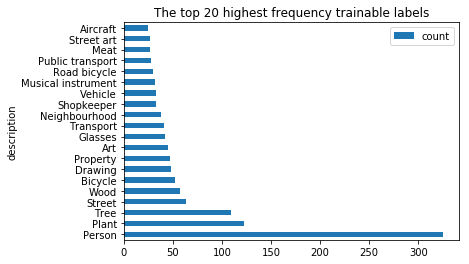

In [67]:
plt.figure(figsize = (20,2))
tuning_labels_separate_df[['count','description']][0:20].plot.barh(x='description', y='count')
plt.title('The top 20 highest frequency trainable labels')
plt.show()

---

In [14]:
train_bbox = pd.read_csv('../dat/train_bounding_boxes.csv')

In [15]:
train_bbox.shape

(14610229, 13)

In [16]:
train_bbox.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,0,0,0
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,0,0,0
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,0,0,0
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,0,0,0
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,0,0,0


In [17]:
imageIDs = train_bbox['ImageID'].values
labelnames = train_bbox['LabelName'].values

In [18]:
imageIDs = np.unique(imageIDs)
labelnames = np.unique(labelnames)

In [19]:
imageIDs.shape, labelnames.shape

((1743042,), (599,))

There are 1743042 distinct images with bounding boxes.
And 599 distinct labels in total.

---

According to Dataset website ([*OpenImage*](https://storage.googleapis.com/openimages/web/download.html)):
   - **ImageID**: the image this box is in
   
   - **Source**: 
       1. *freeform* and *xclick* are drawn manually
       2. *activemil* machine generated (human verified to be accurate at IoU>0.7)
       
   - **LabelName**: object class that this box belongs to
   
   - **Confidence**: dummy value, always 1
   
   - **XMin, XMax, YMin, YMax**: coordinates of the box
     [0,1] where for X, 0 is the leftmost pixel and 1 is the rightmost pixel. (for y, that is top to bottom)

For sttributes below, 1 indicates *present*, 0 *not present*, -1 *unknown*.
   
   - **IsOccluded**: object is occluded by another object
   
   - **IsTruncated**: object extends beyond the boundary of the image
   
   - **IsGroupOf**: box spans a group of pbjects (this tag is for cases with more than 5 instances which are heavily occluding each other and are physically touching)
   
   - **IsDepiction**: indicate the object is a depiction:  (e.g., a cartoon or drawing of the object, not a real physical instance)
   
   - **IsInside**: picture is taken from the inside of the object (e.g., car interior or inside of a building)
   

---

In [20]:
sample_bbox = train_bbox.loc[train_bbox['ImageID'] == '000002b66c9c498e']

In [21]:
sample_bbox

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,0,0,0
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,0,0,0
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,0,0,0
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,0,0,0
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,0,0,0
5,000002b66c9c498e,xclick,/m/01g317,1,0.320312,0.368750,0.260938,0.328125,1,0,0,0,0
6,000002b66c9c498e,xclick,/m/01g317,1,0.412500,0.945312,0.120312,0.475000,1,0,1,0,0
7,000002b66c9c498e,xclick,/m/0284d,1,0.528125,0.923437,0.675000,0.964063,0,0,0,0,0
8,000002b66c9c498e,xclick,/m/04bcr3,1,0.064062,0.492188,0.889063,0.993750,0,0,0,0,0
9,000002b66c9c498e,xclick,/m/04bcr3,1,0.301562,0.990625,0.462500,0.595312,0,0,0,0,0


In [228]:
image = cv2.imread('../dat/train_img/train_0/000002b66c9c498e.jpg')

In [229]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

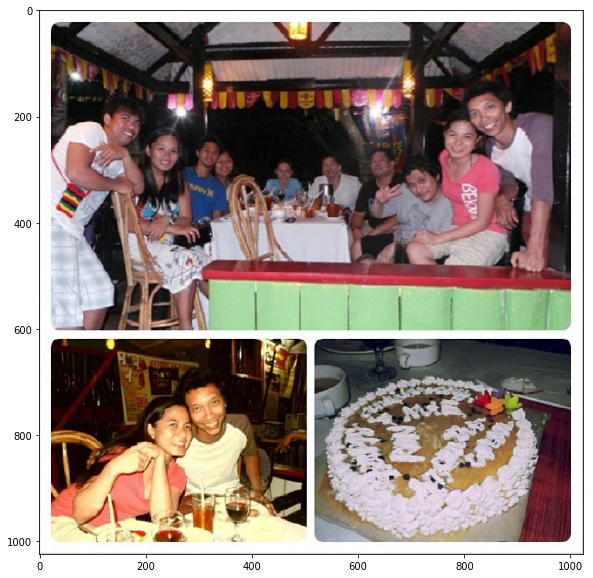

In [230]:
plt.figure(figsize = (10,10))
plt.imshow(image)
plt.show()

In [231]:
width, height, channels = np.shape(image)

In [232]:
coordinates = sample_bbox[['XMin','XMax','YMin','YMax']]

In [233]:
coordinates

,XMin,XMax,YMin,YMax
0,0.012500,0.195312,0.148438,0.587500
1,0.025000,0.276563,0.714063,0.948438
2,0.151562,0.310937,0.198437,0.590625
3,0.256250,0.429688,0.651563,0.925000
4,0.257812,0.346875,0.235938,0.385938
5,0.320312,0.368750,0.260938,0.328125
6,0.412500,0.945312,0.120312,0.475000
7,0.528125,0.923437,0.675000,0.964063
8,0.064062,0.492188,0.889063,0.993750
9,0.301562,0.990625,0.462500,0.595312


In [234]:
rows, cols = coordinates.shape
for i in range(rows):
    bbox_cor = coordinates.iloc[i]
    actual_cor = []
    for j in range(cols):
        actual_cor.append(int(width*bbox_cor[j]))
    cv2.rectangle(image, (actual_cor[0], actual_cor[2]), (actual_cor[1], actual_cor[3]), (0, 255, 0), 2)

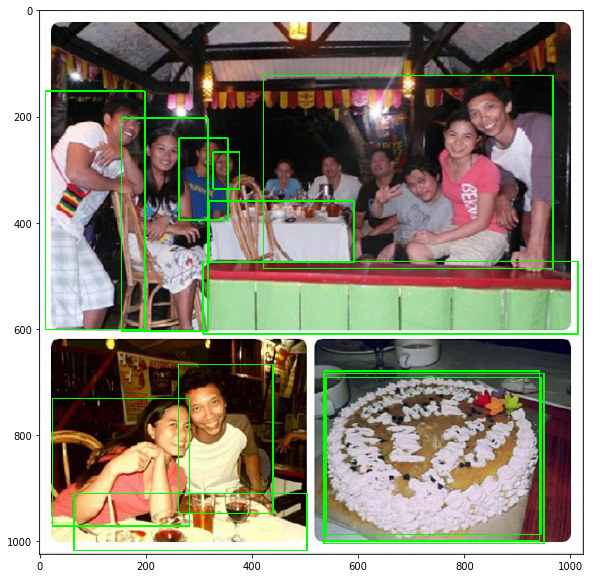

In [235]:
plt.figure(figsize = (10,10))
plt.imshow(image)
plt.show()

In [248]:
label_descriptions_copy = label_descriptions.copy()
label_descriptions_copy.columns = ['LabelName','description']

In [249]:
label_descriptions_copy.head()

,LabelName,description
0,/m/0100nhbf,Sprenger's tulip
1,/m/0104x9kv,Vinegret
2,/m/0105jzwx,Dabu-dabu
3,/m/0105ld7g,Pistachio ice cream
4,/m/0105lxy5,Woku


In [236]:
sample_bbox_new = pd.merge(sample_bbox, label_descriptions_copy, on='LabelName', how='left')

In [237]:
sample_bbox_new

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,description
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,0,0,0,Person
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,0,0,0,Person
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,0,0,0,Person
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,0,0,0,Person
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,0,0,0,Person
5,000002b66c9c498e,xclick,/m/01g317,1,0.320312,0.368750,0.260938,0.328125,1,0,0,0,0,Person
6,000002b66c9c498e,xclick,/m/01g317,1,0.412500,0.945312,0.120312,0.475000,1,0,1,0,0,Person
7,000002b66c9c498e,xclick,/m/0284d,1,0.528125,0.923437,0.675000,0.964063,0,0,0,0,0,Dairy
8,000002b66c9c498e,xclick,/m/04bcr3,1,0.064062,0.492188,0.889063,0.993750,0,0,0,0,0,Table
9,000002b66c9c498e,xclick,/m/04bcr3,1,0.301562,0.990625,0.462500,0.595312,0,0,0,0,0,Table


In [238]:
col_name = sample_bbox_new.columns.values

In [239]:
col_name = sample_bbox_new.columns.values
col_name[3] = 'description'
col_name[-1] = 'Confidence'

In [240]:
col_name

array(['ImageID', 'Source', 'LabelName', 'description', 'XMin', 'XMax',
       'YMin', 'YMax', 'IsOccluded', 'IsTruncated', 'IsGroupOf',
       'IsDepiction', 'IsInside', 'Confidence'], dtype=object)

In [241]:
sample_bbox_new_reid = sample_bbox_new[col_name].copy()
# sample_bbox_new.columns = col_name

In [242]:
sample_bbox_new_reid.columns = col_name

In [243]:
sample_bbox_new_reid

,ImageID,Source,LabelName,description,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,Confidence
0,000002b66c9c498e,xclick,/m/01g317,Person,0.012500,0.195312,0.148438,0.587500,0,1,0,0,0,1
1,000002b66c9c498e,xclick,/m/01g317,Person,0.025000,0.276563,0.714063,0.948438,0,1,0,0,0,1
2,000002b66c9c498e,xclick,/m/01g317,Person,0.151562,0.310937,0.198437,0.590625,1,0,0,0,0,1
3,000002b66c9c498e,xclick,/m/01g317,Person,0.256250,0.429688,0.651563,0.925000,1,0,0,0,0,1
4,000002b66c9c498e,xclick,/m/01g317,Person,0.257812,0.346875,0.235938,0.385938,1,0,0,0,0,1
5,000002b66c9c498e,xclick,/m/01g317,Person,0.320312,0.368750,0.260938,0.328125,1,0,0,0,0,1
6,000002b66c9c498e,xclick,/m/01g317,Person,0.412500,0.945312,0.120312,0.475000,1,0,1,0,0,1
7,000002b66c9c498e,xclick,/m/0284d,Dairy,0.528125,0.923437,0.675000,0.964063,0,0,0,0,0,1
8,000002b66c9c498e,xclick,/m/04bcr3,Table,0.064062,0.492188,0.889063,0.993750,0,0,0,0,0,1
9,000002b66c9c498e,xclick,/m/04bcr3,Table,0.301562,0.990625,0.462500,0.595312,0,0,0,0,0,1


In [244]:
label = sample_bbox_new_reid[['description','XMin','XMax','YMin','YMax']]

In [245]:
label

,description,XMin,XMax,YMin,YMax
0,Person,0.012500,0.195312,0.148438,0.587500
1,Person,0.025000,0.276563,0.714063,0.948438
2,Person,0.151562,0.310937,0.198437,0.590625
3,Person,0.256250,0.429688,0.651563,0.925000
4,Person,0.257812,0.346875,0.235938,0.385938
5,Person,0.320312,0.368750,0.260938,0.328125
6,Person,0.412500,0.945312,0.120312,0.475000
7,Dairy,0.528125,0.923437,0.675000,0.964063
8,Table,0.064062,0.492188,0.889063,0.993750
9,Table,0.301562,0.990625,0.462500,0.595312


In [246]:
rows, cols = label.shape
for i in range(rows):
    bbox_cor = label.iloc[i]
    actual_cor = []
    for j in range(1, cols):
        actual_cor.append(int(width*bbox_cor[j]))
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image,bbox_cor[0],(actual_cor[0],actual_cor[2]-5), font, 0.8,(0,255,0),2,cv2.LINE_AA)
#     cv2.rectangle(image, (actual_cor[0], actual_cor[2]), (actual_cor[1], actual_cor[3]), (0, 255, 0), 2)

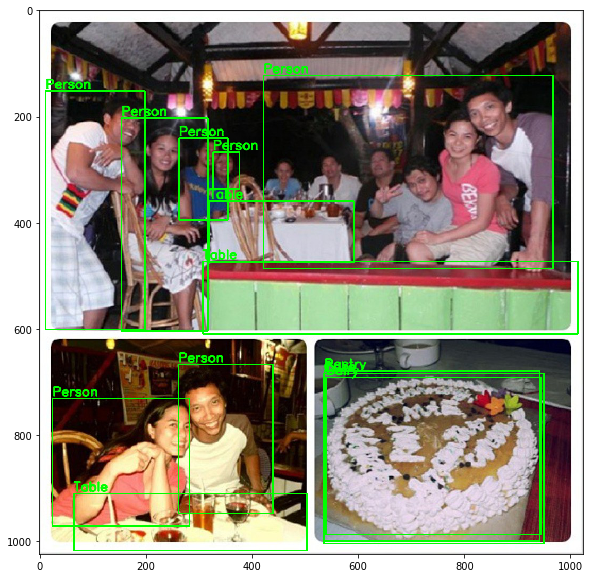

In [247]:
plt.figure(figsize = (10,10))
plt.imshow(image)
plt.show()

---

## Help wanted here as well!
I'm trying to link the label name with its text description in the boundary box dataset.
But...

In [250]:
train_bbox_subset = train_bbox[['ImageID', 'LabelName']].copy()

In [251]:
train_bbox_subset.head()

,ImageID,LabelName
0,000002b66c9c498e,/m/01g317
1,000002b66c9c498e,/m/01g317
2,000002b66c9c498e,/m/01g317
3,000002b66c9c498e,/m/01g317
4,000002b66c9c498e,/m/01g317


In [252]:
train_bbox_subset.shape, label_descriptions_copy.shape

((14610229, 2), (19987, 2))

In [253]:
merged_descripID = pd.merge(train_bbox_subset, label_descriptions_copy, on='LabelName', how='left')

In [254]:
merged_descripID.shape

(14610229, 3)

In [255]:
merged_descripID

,ImageID,LabelName,description
0,000002b66c9c498e,/m/01g317,Person
1,000002b66c9c498e,/m/01g317,Person
2,000002b66c9c498e,/m/01g317,Person
3,000002b66c9c498e,/m/01g317,Person
4,000002b66c9c498e,/m/01g317,Person
5,000002b66c9c498e,/m/01g317,Person
6,000002b66c9c498e,/m/01g317,Person
7,000002b66c9c498e,/m/0284d,Dairy
8,000002b66c9c498e,/m/04bcr3,Table
9,000002b66c9c498e,/m/04bcr3,Table


Notice row 14610215: 
 - ImageID:fffffdaec951185d 
 - LabelName:/m/03bt1vf 
 - description: **NaN**

If we drop NaN...

In [256]:
merged_descripID_dropNan = merged_descripID.copy()

In [257]:
merged_descripID_dropNan = merged_descripID_dropNan.dropna()

In [258]:
merged_descripID_dropNan.shape

(12139588, 3)

This means there are 2470641 non entries...

But! If I go back to the dataset download page [here](https://storage.googleapis.com/openimages/web/download.html) and download the *Metadata* in *Subset with Bounding Boxes*

In [259]:
new_label = pd.read_csv('../dat/class-descriptions-boxable.csv',header=None)

In [260]:
new_label.columns = ['LabelName','description']

In [261]:
merged_descripID_new = pd.merge(train_bbox_subset, new_label, on='LabelName', how='left')

In [262]:
merged_descripID_new

,ImageID,LabelName,description
0,000002b66c9c498e,/m/01g317,Person
1,000002b66c9c498e,/m/01g317,Person
2,000002b66c9c498e,/m/01g317,Person
3,000002b66c9c498e,/m/01g317,Person
4,000002b66c9c498e,/m/01g317,Person
5,000002b66c9c498e,/m/01g317,Person
6,000002b66c9c498e,/m/01g317,Person
7,000002b66c9c498e,/m/0284d,Dairy
8,000002b66c9c498e,/m/04bcr3,Table
9,000002b66c9c498e,/m/04bcr3,Table


In [263]:
merged_descripID_new.copy().dropna().shape

(14610229, 3)

I don't get any NaN entry!

Anyway, if we stick to this version...

In [269]:
label_counts = merged_descripID_new.description.value_counts()

In [287]:
label_counts_df = pd.DataFrame({'label': label_counts.index.tolist(), 'Number of label': label_counts})
label_counts_df.reset_index(drop=True, inplace=True)

In [288]:
label_counts_df.head()

,Number of label,label
0,1438128,Clothing
1,1418594,Man
2,1051344,Tree
3,1037710,Human face
4,1034721,Person


<Figure size 1440x144 with 0 Axes>

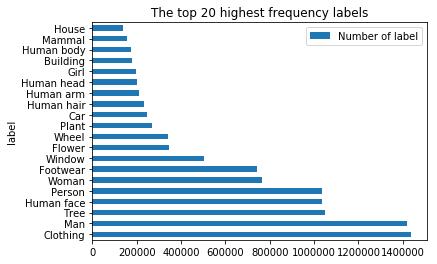

In [292]:
plt.figure(figsize = (20,2))
label_counts_df[0:20].plot.barh(x='label', y='Number of label')
plt.title('The top 20 highest frequency labels')
plt.show()